In [1]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, PreTrainedTokenizerFast, DataCollatorForLanguageModeling
import torch
import torch.nn as nn
import sys
import numpy as np
sys.path.append("../VAE_standard")
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM, VAE

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.patches import FancyBboxPatch
from highlight_text import fig_text, ax_text

sys.path.append("..")
import utils

import Bio.Data.CodonTable

from devinterp.utils import (
    EvaluateFn,
    EvalResults,
)

from BIF_sampler import (
    BIFEstimator,
    estimate_bif
)

import copy

## Data preparation

In [2]:
MAX_TOKEN_LENGTH = 1020
BATCH_SIZE=60
num_masks = 3

TEST_SEQ = 1
TRAIN_CUTOFF = 1000
TEST_TOKEN = 0

DEVICE = "cuda"

In [3]:
dataset = DNADataset(f"../data/training_spike.fasta")
sequences = [utils.get_genome(np.dot(x[0], np.arange(len(ALPHABET)))) for x in dataset]
print("done extracting sequences!")

str_sequences = [[x for x in seq][:MAX_TOKEN_LENGTH] for seq in np.unique(["".join(x).replace("-","") for x in sequences])]
print("done removing gaps!")

test_seq = str_sequences[TEST_SEQ-1:TEST_SEQ]
masked_seqs = [seq.copy() for j in range(MAX_TOKEN_LENGTH // num_masks) for seq in test_seq]
labeled_seqs = [seq for j in range(MAX_TOKEN_LENGTH // num_masks) for seq in test_seq]
print("done creating element copies!")

done extracting sequences!
done removing gaps!
done creating element copies!


In [4]:
for i in range(len(masked_seqs)):
    j = i % (MAX_TOKEN_LENGTH // num_masks)
    for k in range(num_masks * j, num_masks * (j+1)):
        masked_seqs[i][k] = "<mask>"

In [5]:
masked_seqs = ["".join(x) for x in masked_seqs]
print("done creating bif masks!")

labeled_seqs = ["".join(seq) for seq in labeled_seqs]
print("done creating bif labels!")

train_data = ["".join(seq).replace("-","")[:MAX_TOKEN_LENGTH] for seq in sequences[:TRAIN_CUTOFF]]
print("done creating sgld dataset!")

done creating bif masks!
done creating bif labels!
done creating sgld dataset!


In [6]:
print(len(masked_seqs))
print(len(masked_seqs))
print(len(train_data))

340
340
1000


## Loading ESM model

In [8]:
"""
tokenizer: 
input_ids - torch.LongTensor of shape (batch_size, sequence_length)
attention_mask - torch.Tensor of shape (batch_size, sequence_length), Mask values selected in {0,1}, where 0 := masked, 1 := not masked
"""

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D").to(DEVICE)

/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15, return_tensors="pt")
sgld_dataset = tokenizer(text=train_data, return_tensors="pt", add_special_tokens=False, truncation=False)["input_ids"]
sgld_inputs, sgld_labels = data_collator.torch_mask_tokens(sgld_dataset)

sgld_inputs = sgld_inputs.to(DEVICE)
sgld_labels = sgld_labels.to(DEVICE)

print(sgld_inputs.shape)
print(sgld_labels.shape)

torch.Size([1000, 1020])
torch.Size([1000, 1020])


In [10]:
bif_inputs = tokenizer(text=masked_seqs, return_tensors="pt", add_special_tokens=False, truncation=False)
bif_labels = tokenizer(text=labeled_seqs, return_tensors="pt", add_special_tokens=False, truncation=False)["input_ids"]
bif_labels = torch.where(bif_inputs["input_ids"] == tokenizer.mask_token_id, bif_labels, -100)

bif_labels = bif_labels.to(DEVICE)
bif_inputs["input_ids"] = bif_inputs["input_ids"].to(DEVICE)
bif_inputs["attention_mask"] = bif_inputs["attention_mask"].to(DEVICE)

print(bif_inputs["input_ids"].shape)
print(bif_labels.shape)

torch.Size([340, 1020])
torch.Size([340, 1020])


In [11]:
bif_dataloader = torch.utils.data.DataLoader(list(zip(zip(bif_inputs["input_ids"], bif_inputs["attention_mask"]), bif_labels)), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [12]:
test_seq = tokenizer(text=masked_seqs[TEST_TOKEN], return_tensors="pt", add_special_tokens=False, truncation=False)
test_seq_label = tokenizer(text=labeled_seqs[TEST_TOKEN], return_tensors="pt", add_special_tokens=False, truncation=False)["input_ids"]

test_seq_label = test_seq_label.squeeze().to(DEVICE)
test_seq["input_ids"] = test_seq["input_ids"].to(DEVICE)
test_seq["attention_mask"] = test_seq["attention_mask"].to(DEVICE)

## Per-token BIF algorithm
<img src="./per_tok_BIF.png" width="1000" height="1000"/>

### For MLM models like ESM, $\ell_i(w) = -\sum_{s\in [M]}^S log(p(z_{i,s} | z_{i,[M]^c}))$, where $[M]$ is random mask. Then, I define $\ell_{i,s}(w) = -log(p(z_{i,s} | z_{i,\{s\}^c}))$, i.e. the loss of a single token is the cross-entropy loss of masking that single token

### Define sequences $\{x_i\}_{i=1}^N$ where $x_i = (x_{i,1},...x_{i,S})$ and $S:=$length of sequence. Then, I fix one amino-acid $x_{i,j}$ and calculate $BIF(*,x_{i,j}$)

In [13]:
def get_loss_vec(
    model,
    dataloader=bif_dataloader, 
    vocab_size=tokenizer.vocab_size, 
    num_data = MAX_TOKEN_LENGTH // num_masks,
    batch_size = BATCH_SIZE
):
    """
    dataloader: (torch.utils.DataLoader) where each element is of the form ((input, attention_mask), label)
    vocab_size: number of unique tokens in tokenizer (tokenizer.vocab_size)
    model: ESM model

    returns: array of losses which is used to calculate BIF matrix
    """
    loss_vec = torch.zeros(num_data).to(DEVICE)
    with torch.no_grad():
        for i, ((test_input, test_mask), test_labels) in enumerate(dataloader):
            bsize = test_input.shape[0]
            outputs = model(test_input, attention_mask=test_mask)["logits"] # returns tensor of size (batch, seq_length, vocab_size)
            batch_loss = torch.sum(nn.functional.cross_entropy(outputs.view(-1,vocab_size), target=test_labels.view(-1), ignore_index=-100, reduction="none").view(bsize, -1), dim=-1)
            if i < len(dataloader) - 1:
                loss_vec[i * batch_size : (i+1) * batch_size] = batch_loss
            else:
                loss_vec[i * batch_size:] = batch_loss
            
    return loss_vec

def get_obs(
    model,
    test_seq=((test_seq["input_ids"], test_seq["attention_mask"]), test_seq_label), 
):
    """
    test_seq: tuple of form ((input, attention_mask), label) -- attention_mask should be tensor of same length as input tensor and containing only 1s
        input has shape (1, seq_length)
        attention_mask has shape (1, seq_length)
        label has shape (seq_length)
    model: ESM model

    returns: loss value used to calculate BIF_matrix
    """
    (test_input, test_mask), test_label = test_seq
    with torch.no_grad():
        test_output = model(test_input, attention_mask=test_mask)["logits"].squeeze()
        return torch.tensor(nn.functional.cross_entropy(test_output, target=test_label, ignore_index=-100, reduction="sum").item())

In [14]:
def evaluate_function(model: nn.Module, data: torch.Tensor, device=DEVICE) -> EvalResults:
    """
    model (torch.nn.module): ESM model
    data (torch.Tensor): minibatch data used to update weights of model in SGLD
    device (String): either "cuda" or "cpu"

    returns:
    dictionary with 
    (i) loss - loss used to update weights of model
    (ii) obs - calculated observables (in this case cross-entropy loss on one test token) as described above
    (iii) loss_vec - the losses evaluated at every training point for the model used to compute the BIF as described in the algorithm at the top
    """

    inputs, targets = data
    return {
        "loss": model(inputs, labels=targets).loss,
        "obs": get_obs(model=model),
        "loss_vec": get_loss_vec(model=model)
    }

sgld_dataloader = torch.utils.data.DataLoader(list(zip(sgld_inputs, sgld_labels)), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

## Estimating BIF on test_seq

In [15]:
"""
Con - have to create copy of the model for each chain (model is 10 GB x num_chains = big)
"""

ESM_BIF = estimate_bif(
    model=model,
    loader = sgld_dataloader,
    evaluate = evaluate_function,
    num_obs=1,
    device=DEVICE,
    num_chains=6,
    num_draws=10,
    num_data=MAX_TOKEN_LENGTH // num_masks
)

/home/averma2/code/devinterp/src/devinterp/backends/default/slt/sampler.py:262: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/averma2/code/devinterp/src/devinterp/backends/default/slt/sampler.py:311: UserWarning: If you're setting a nbeta or temperature in sampling_method_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
Chain 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.02s/it]


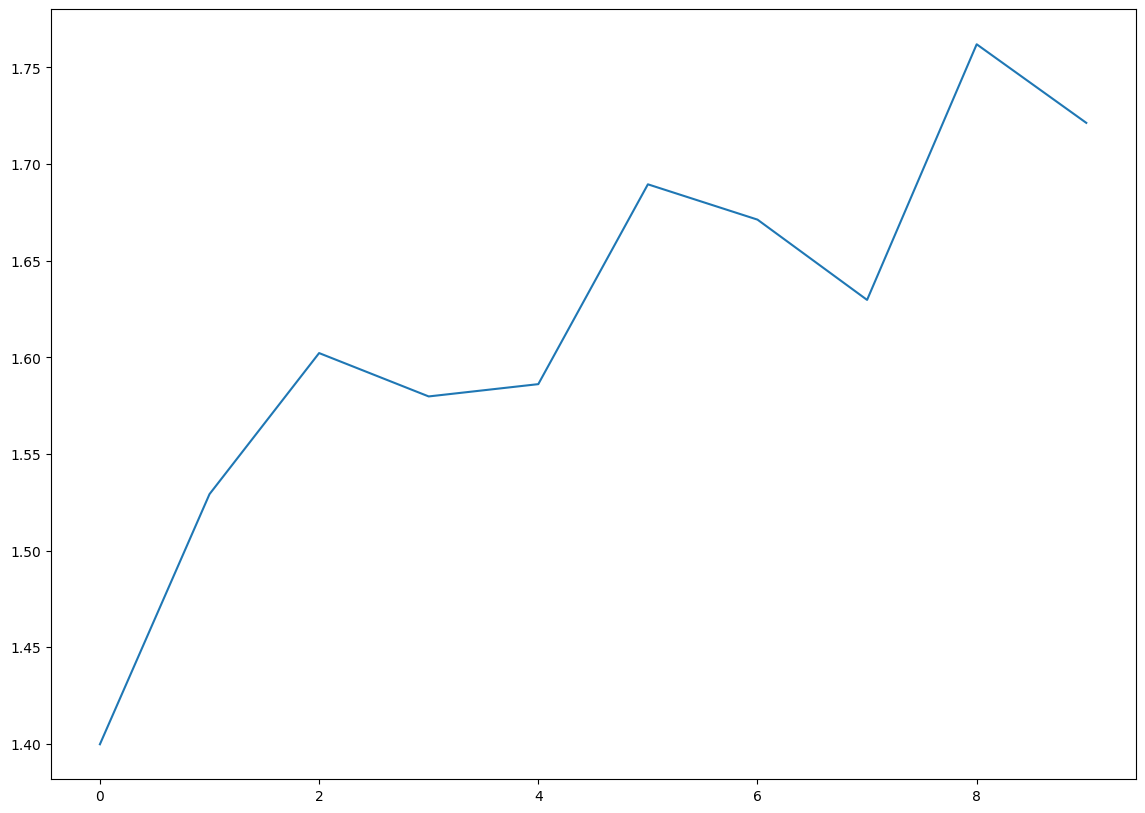

In [16]:
fig, arr = plt.subplots(1,1,figsize=(14,10))

losses = ESM_BIF["sgld_loss/trace"]
arr.plot(np.arange(losses.shape[1]), losses[5])
plt.show()

## Visualizations

In [17]:
test_seq = "".join(str_sequences[TEST_SEQ])
test_seq = ["<%s>"%(test_seq[num_masks * i : num_masks * (i+1)]) for i in range(len(test_seq) // num_masks)]

computed_influences = ESM_BIF["BIF"].squeeze(-1)

In [18]:
print(computed_influences.shape)

(340,)


In [19]:
NUM_BINS = 100
DISP_BATCH = 20
cmap = mpl.colormaps['RdBu_r']
colors = cmap(np.linspace(0, 1, NUM_BINS))

def rgb_to_hex(r, g, b):
    return "#{:02X}{:02X}{:02X}".format(int(r*255), int(g*255), int(b*255))

def normalize(arr, num_bins=NUM_BINS):
    norm_arr = arr / (2*np.max(arr)) + 0.5
    bin_arr = np.digitize(norm_arr, np.linspace(0, 1, num_bins-1))
    return bin_arr

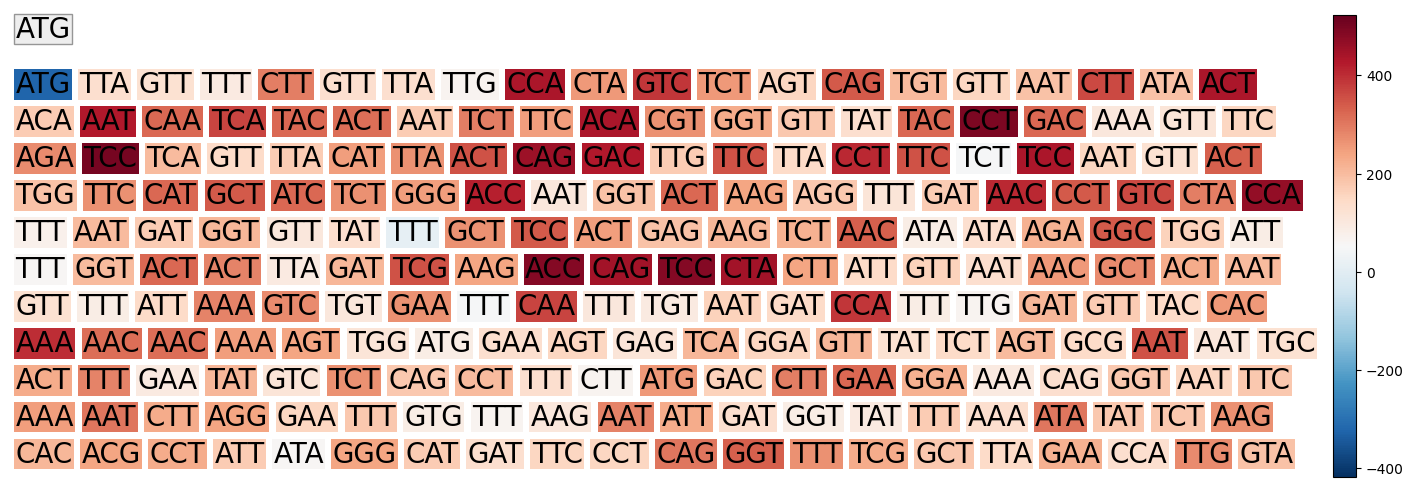

In [20]:
fig,arr = plt.subplots(1,1,figsize=(20,6))
arr.axis((0,5,0,5))
i = 0
norm_influences = normalize(computed_influences)

ax_text(
        x=0,  # position on x-axis
        y=5,  # position on y-axis
        s=test_seq[TEST_TOKEN],
        fontsize=20,
        ax=arr,
        highlight_textprops=[
            {"bbox": {"edgecolor": "#969696",
                      "facecolor": "#EEEEEE",
                      "linewidth": 1,
                      "pad": 1}}
        ]
    )

while (i * 20 < len(test_seq)):
    subseq = test_seq[i * DISP_BATCH : (i + 1) * DISP_BATCH]
    influences = norm_influences[i * DISP_BATCH : (i + 1) * DISP_BATCH]
    ax_text(
        x=0,  # position on x-axis
        y=4.4 - 0.4 * i,  # position on y-axis
        s=" ".join(subseq),
        fontsize=20,
        ax=arr,
        highlight_textprops=[
            {"bbox": {"edgecolor": "#FFFFFF",
                      "facecolor": colors[influences[i]],
                      "linewidth": 0,
                      "pad": 1}} for i in range(len(subseq))
        ]
    )
    i += 1
    if i > 10:
        break
arr.set_axis_off()
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(computed_influences), np.max(computed_influences)), cmap='RdBu_r'), ax=arr)
plt.show()